In [1]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import stats
import scipy.stats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import glob
import time
import pandas as pd
import math
plt.rcParams["figure.figsize"] = (3,3)



print (time.ctime())

Fri Feb 12 18:40:35 2021


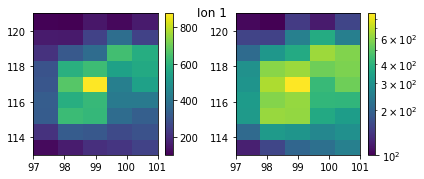

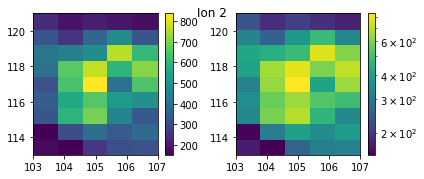

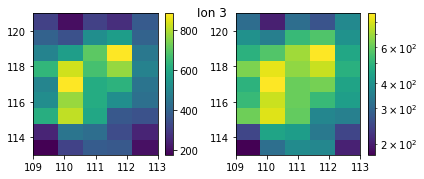

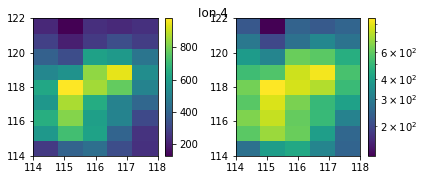

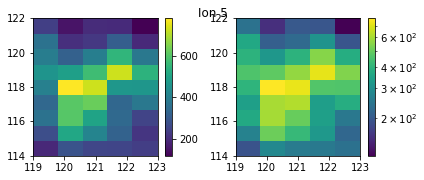

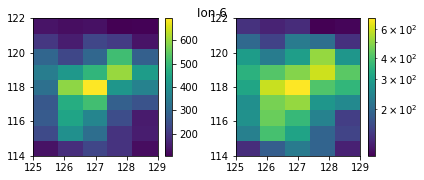

In [3]:
### Call the modules that have both the File information and the functions to perform the analysis ###
import Ion_functions as func
from Ion_functions import Ion
import choose_file 
choose_file.Jumps_Six_350V_1(True) #file selection, plots ROI's to verify number and location of Ions. 

Ion 1 threshold: 1.89e-02(s)
Bright events (#/%): 14920 / 91.01% 

Ion 2 threshold: 1.61e-02(s)
Bright events (#/%): 17398 / 89.71% 

Ion 3 threshold: 1.51e-02(s)
Bright events (#/%): 19876 / 90.16% 

Ion 4 threshold: 1.56e-02(s)
Bright events (#/%): 20285 / 91.32% 

Ion 5 threshold: 1.80e-02(s)
Bright events (#/%): 15405 / 89.23% 

Ion 6 threshold: 2.06e-02(s)
Bright events (#/%): 11841 / 89.30% 



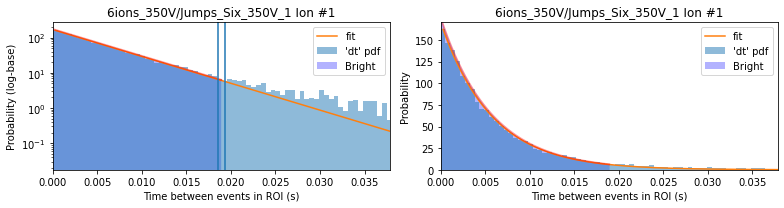

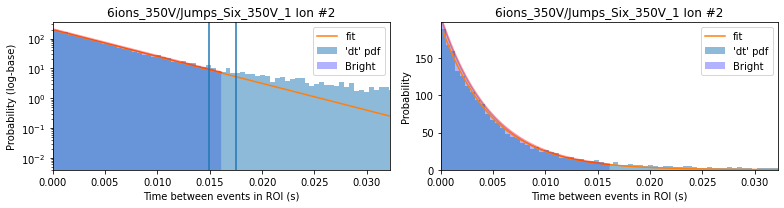

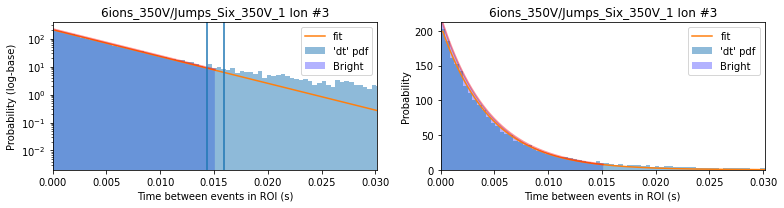

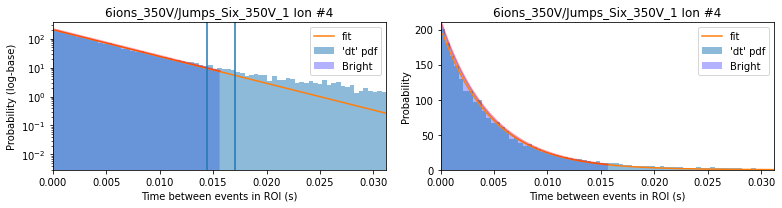

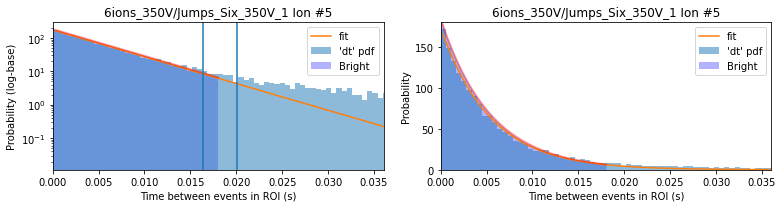

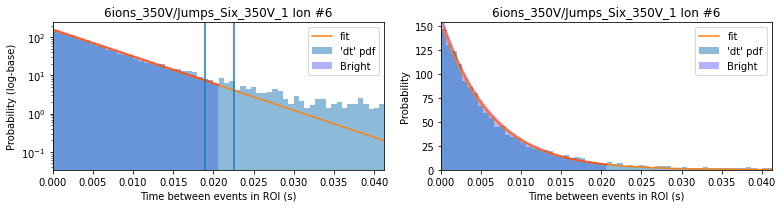

In [4]:
ion_1 = choose_file.ion_1
ion_2 = choose_file.ion_2
ion_3 = choose_file.ion_3
ion_4 = choose_file.ion_4
ion_5 = choose_file.ion_5
ion_6 = choose_file.ion_6
Ion_1 = choose_file.Ion_1
Ion_2 = choose_file.Ion_2
Ion_3 = choose_file.Ion_3
Ion_4 = choose_file.Ion_4
Ion_5 = choose_file.Ion_5
Ion_6 = choose_file.Ion_6

filename = choose_file.filename
old_data_table = choose_file.old_data_table
data_table = choose_file.data_table

sigma = 1.8
uncertainty = True
single_photon = True
ion_1.setup(sigma, uncertainty, single_photon)
ion_2.setup(sigma, uncertainty, single_photon)
ion_3.setup(sigma, uncertainty, single_photon)
ion_4.setup(sigma, uncertainty, single_photon)
ion_5.setup(sigma, uncertainty, single_photon)
ion_6.setup(sigma, uncertainty, single_photon)

In [5]:
data_table

,index,y,x,time,center flux,cluster size,dt
0,0,116,99,0.052632,2125,8,0.008012
1,1,117,101,0.060645,1675,8,0.000021
2,2,120,100,0.060666,1675,6,0.002993
3,3,120,98,0.063659,2475,12,0.004715
4,4,117,101,0.068374,2125,9,0.004985
...,...,...,...,...,...,...,...
13255,13255,120,128,165.934828,2175,8,0.001745
13256,13256,119,128,165.936573,2850,10,0.004180
13257,13257,119,126,165.940753,1325,7,0.001664
13258,13258,119,127,165.942417,1675,8,0.005051


# Afterpulsing Analysis 

In [19]:
#Loop that creates and saves the difference in time between events in the ROI
data_table = data_table.sort_values(['time'])
data_table = data_table.reset_index(drop = True)
name = data_table
dt_whole = []
for i in range(0, len(name)-1):
    dt_whole.append(name.at[i+1, 'time'] - name.at[i, 'time'])
dt_whole.append(0)
data_table['dt_whole'] = dt_whole
data_table['index'] = np.arange(len(name)) # new index is used in certain functions in class: "Ion"
    


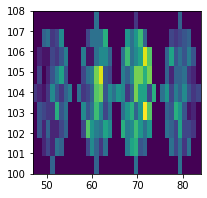

In [31]:
it = data_table.query('dt_whole < 2e-7')
index_array = np.array(it['index'])
index_array += 0

it['y'].max()-it['y'].min()
index_array
xx = np.array(data_table['x'])
yy = np.array(data_table['y'])
x = []; y = []; 
for i in range(len(index_array)-1):
    indexer = int(index_array[i])
    x.append(xx[indexer])
    y.append(yy[indexer])
h = plt.hist2d(x, y, bins = (38, 9))


2.564102564102564e-09

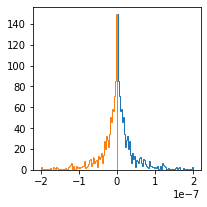

In [20]:
duration = 2e-7
bins = 19*4+2
h = plt.hist(data_table['dt_whole'], bins = bins, range = [0, duration], histtype = 'step')
h = plt.hist(-data_table['dt_whole'], bins = bins, range = [-duration, 0], histtype = 'step')
duration/bins

In [21]:
#Loop that creates and saves the difference in time between events in the ROI
old_data_table = old_data_table.sort_values(['time'])
old_data_table = old_data_table.reset_index(drop = True)
name = old_data_table
dt_whole = []
for i in range(0, len(name)-1):
    dt_whole.append(name.at[i+1, 'time'] - name.at[i, 'time'])
dt_whole.append(0)
old_data_table['dt_whole'] = dt_whole
old_data_table['index'] = np.arange(len(name)) # new index is used in certain functions in class: "Ion"
    


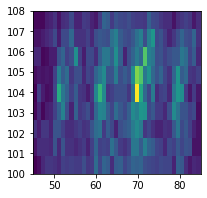

In [33]:
it = old_data_table.query('dt_whole < .5e-7')
index_array = np.array(it['index'])
index_array += 0

index_array
xx = np.array(old_data_table['x'])
yy = np.array(old_data_table['y'])
x = []; y = []; 
for i in range(len(index_array)-1):
    indexer = int(index_array[i])
    x.append(xx[indexer])
    y.append(yy[indexer])
h = plt.hist2d(x, y, bins = (41, 9), range = ([45,85], [100,108]))

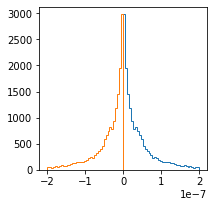

In [23]:
bins = 19*2+1

h = plt.hist(old_data_table['dt_whole'], bins, range = [0e-7, duration], histtype = 'step')
h = plt.hist(-old_data_table['dt_whole'], bins, range = [-duration, 0], histtype = 'step')

Text(0.5, 1.0, 'Plot')

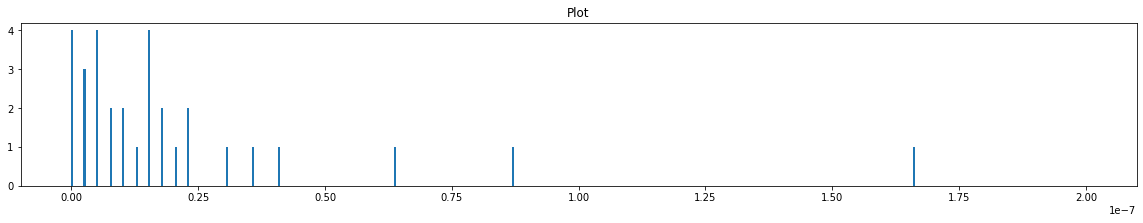

In [68]:
fig, ax = plt.subplots (1, 1, figsize = (20, 3))
ax.hist(Ion_6['dt'], bins = 500, range = (0, 2e-7))
ax.set_title('Plot')

In [6]:
def afterpulse_elements(table_1, table_2, duration, same = False):
    array = []
    x = []
    y = []
    for i in (table_1).index:
        time = table_1.at[i, 'time']
        start = time - duration; end = time + duration
    
        if same == True:
            for j in table_2.query(f'{start}< time < {end} and time != {time}').index:
                array.append(table_2.at[j, 'time'] - time)
                x.append(table_2.at[j, 'x'])
                y.append(table_2.at[j, 'y'])
        
        else:
            for j in table_2.query(f'{start}< time < {end}').index:
                array.append(table_2.at[j, 'time'] - time)
                x.append(table_2.at[j, 'x'])
                y.append(table_2.at[j, 'y'])
    global mark            
    print(f'done [{mark}] || length: {len(array)}')
    mark += 1
        
    return [array, x, y]


In [7]:
mark = 1
duration = .5e-7
array, x, y = afterpulse_elements(ion_1.data, old_data_table, duration)
plt.hist2d(x, y, bins = 21, range = [(x1-10, x1+10), (y1-10, y1+10)])

done [1] || length: 57295


NameError: name 'x1' is not defined

In [ ]:
mark = 1
duration = .5e-7
array, x, y = afterpulse_elements(ion_1.data, old_data_table, duration, same = True)
plt.hist2d(x, y, bins = 21, range = [(x1-10, x1+10), (y1-10, y1+10)])

In [99]:
mark = 1
duration = 2e-7
array_11, x11, y11 = afterpulse_elements(ion_1.data, ion_1.data, duration, same = True)
array_12, x12, y12 = afterpulse_elements(ion_1.data, ion_2.data, duration,)
array_13, x13, y13 = afterpulse_elements(ion_1.data, ion_3.data, duration,)
array_14, x14, y14 = afterpulse_elements(ion_1.data, ion_4.data, duration,)
array_22, x22, y22 = afterpulse_elements(ion_2.data, ion_2.data, duration, same = True)
array_23, x23, y23 = afterpulse_elements(ion_2.data, ion_3.data, duration,)
array_24, x24, y24 = afterpulse_elements(ion_2.data, ion_4.data, duration,)
array_33, x33, y33 = afterpulse_elements(ion_3.data, ion_3.data, duration, same = True)
array_34, x34, y34 = afterpulse_elements(ion_3.data, ion_4.data, duration,)
array_44, x44, y44 = afterpulse_elements(ion_4.data, ion_4.data, duration, same = True)

done [1] || length: 262
done [2] || length: 127
done [3] || length: 35
done [4] || length: 15
done [5] || length: 300
done [6] || length: 250
done [7] || length: 50
done [8] || length: 454
done [9] || length: 200
done [10] || length: 286


In [100]:
afterpulse_correlation = np.array([np.array([len(array_11), len(array_12), len(array_13), len(array_14)]), 
                                                 np.array([0, len(array_22), len(array_23), len(array_24)]),
                                                             np.array([0, 0, len(array_33), len(array_34)]), 
                                                                         np.array([0, 0, 0, len(array_44)])])
afterpulse_correlation

array([[262, 127,  35,  15],
       [  0, 300, 250,  50],
       [  0,   0, 454, 200],
       [  0,   0,   0, 286]])

In [101]:

def expected_count(data, duration):
    count = len(data)/(data['time'].max() - data['time'].min())
    return count
    
np.array([expected_count(Ion_1, duration), expected_count(Ion_2, duration),
          expected_count(Ion_3, duration), expected_count(Ion_4, duration)])

array([338.4799495 , 439.88905939, 549.86478107, 414.4976734 ])

Text(0.5, 0.98, 'After Pulsing Effect +-200ns')

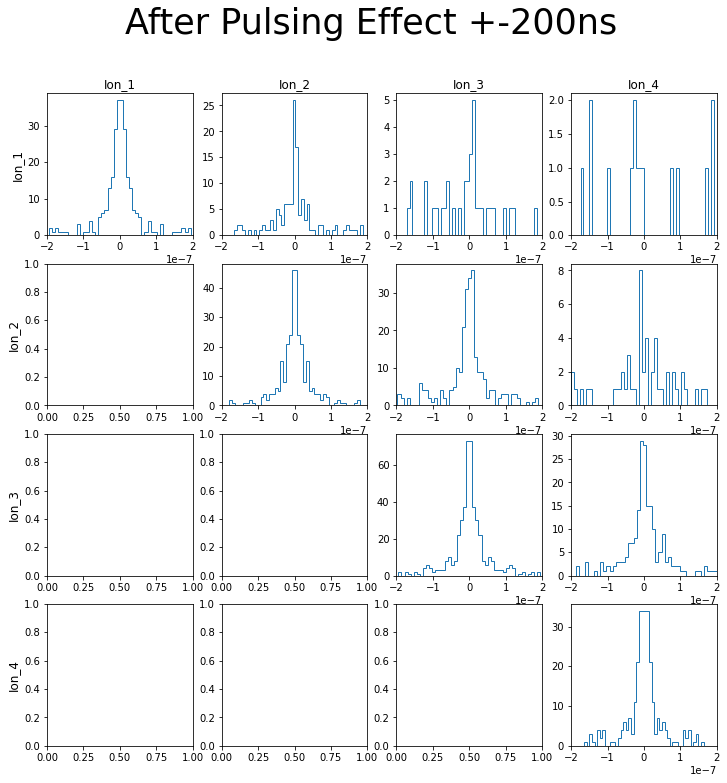

In [102]:
fig, ([ax11, ax12, ax13, ax14], [ax21, ax22, ax23, ax24],
      [ax31, ax32, ax33, ax34], [ax41, ax42, ax43, ax44])= plt.subplots(ncols= 4, nrows = 4, figsize = (12,12))
bins = 46
ax11.hist(array_11, bins = bins, histtype = 'step'); ax11.set_xlim(-duration, duration); ax11.set_title('Ion_1')
ax12.hist(array_12, bins = bins, histtype = 'step'); ax12.set_xlim(-duration, duration); ax12.set_title('Ion_2')
ax13.hist(array_13, bins = bins, histtype = 'step'); ax13.set_xlim(-duration, duration); ax13.set_title('Ion_3')
ax14.hist(array_14, bins = bins, histtype = 'step'); ax14.set_xlim(-duration, duration); ax14.set_title('Ion_4')
ax22.hist(array_22, bins = bins, histtype = 'step'); ax22.set_xlim(-duration, duration)
ax23.hist(array_23, bins = bins, histtype = 'step'); ax23.set_xlim(-duration, duration)
ax24.hist(array_24, bins = bins, histtype = 'step'); ax24.set_xlim(-duration, duration)
ax33.hist(array_33, bins = bins, histtype = 'step'); ax33.set_xlim(-duration, duration)
ax34.hist(array_34, bins = bins, histtype = 'step'); ax34.set_xlim(-duration, duration)
ax44.hist(array_44, bins = bins, histtype = 'step'); ax44.set_xlim(-duration, duration)
ax11.set_ylabel('Ion_1', fontsize = 12)
ax21.set_ylabel('Ion_2', fontsize = 12)
ax31.set_ylabel('Ion_3', fontsize = 12)
ax41.set_ylabel('Ion_4', fontsize = 12)
fig.suptitle('After Pulsing Effect +-200ns', fontsize = 35)


Text(0.5, 0.98, 'After Pulsing Effect +-200ns')

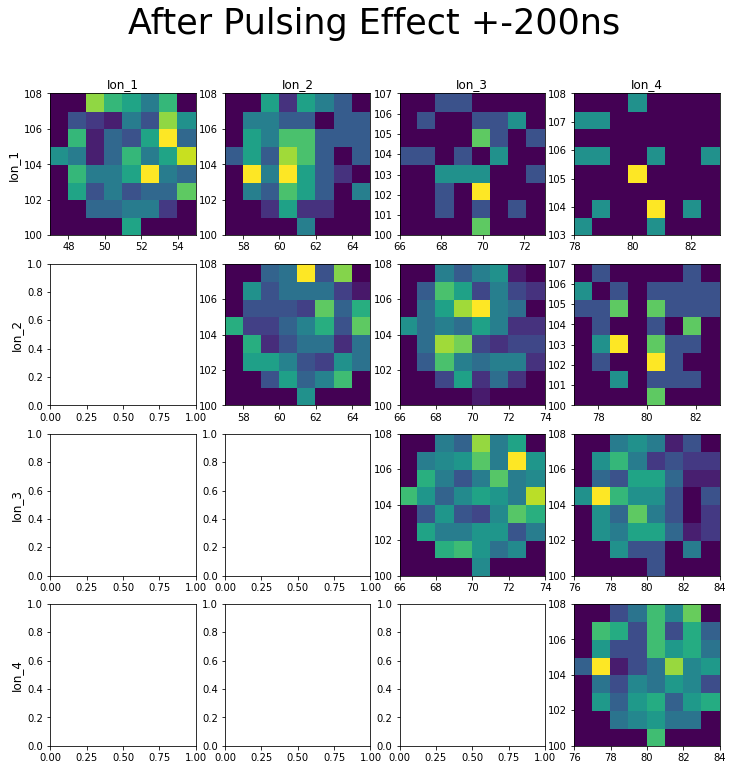

In [103]:
fig, ([ax11, ax12, ax13, ax14], [ax21, ax22, ax23, ax24],
      [ax31, ax32, ax33, ax34], [ax41, ax42, ax43, ax44])= plt.subplots(ncols= 4, nrows = 4, figsize = (12,12))
bins = 25
ax11.hist2d(x11, y11, 8); #ax11.set_xlim(-duration, duration)
ax12.hist2d(x12, y12, 8); #ax12.set_xlim(-duration, duration)
ax13.hist2d(x13, y13, 8); #ax13.set_xlim(-duration, duration)
ax14.hist2d(x14, y14, 8); #ax14.set_xlim(-duration, duration)
ax22.hist2d(x22, y22, 8); #ax22.set_xlim(-duration, duration)
ax23.hist2d(x23, y23, 8); #ax23.set_xlim(-duration, duration)
ax24.hist2d(x24, y24, 8); #ax24.set_xlim(-duration, duration)
ax33.hist2d(x33, y33, 8); #ax33.set_xlim(-duration, duration)
ax34.hist2d(x34, y34, 8); #ax34.set_xlim(-duration, duration)
ax44.hist2d(x44, y44, 8); #ax44.set_xlim(-duration, duration)
ax11.set_ylabel('Ion_1', fontsize = 12); ax11.set_title('Ion_1')
ax21.set_ylabel('Ion_2', fontsize = 12); ax12.set_title('Ion_2')
ax31.set_ylabel('Ion_3', fontsize = 12); ax13.set_title('Ion_3')
ax41.set_ylabel('Ion_4', fontsize = 12); ax14.set_title('Ion_4')
fig.suptitle('After Pulsing Effect +-200ns', fontsize = 35)
